In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy import interp

import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, label_binarize, LabelBinarizer
from sklearn.metrics import r2_score, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

import xgboost as xgb
from xgboost import XGBClassifier

import catboost as cb
from catboost import CatBoostClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None

In [2]:
a = pd.read_csv('C:/Users/Barca/Desktop/GitHub/IPO_Analysis/model_ver_based_on_2019/wave_2/1_DataPreparation/venture_funded_companies_09_18.csv')
nasd = pd.read_csv('NASDAQ_1990_2021.csv', sep=';')
a = a.loc[(~a['raised_amount_usd'].isin([np.nan, 0])) & (~a['post_money_valuation_usd'].isin([np.nan, 0]))]
a = a[['company_name', 'investment_type', 'raised_amount_usd', 'post_money_valuation_usd', 'announced_on']]
c = a.groupby(['raised_amount_usd', 'post_money_valuation_usd']).size().reset_index(name='count_both').sort_values(by = ['count_both'], ascending=False)
#b = a.groupby('company_name').size().reset_index(name='count').sort_values(by = ['count'], ascending=False)
#b = b.loc[b['count']>1]
#a = a.loc[a['company_name'].isin(b['company_name'])]
a['count_round'] = a.groupby(['raised_amount_usd'])['raised_amount_usd'].transform('count')
a['count_cap'] = a.groupby(['post_money_valuation_usd'])['post_money_valuation_usd'].transform('count')
a = a.sort_values(by = ['company_name'], ascending=False)
a = a.merge(c, how = 'left', on = ['raised_amount_usd', 'post_money_valuation_usd'])
a['is_primary'] = 1
a.loc[a['investment_type'].isin(['corporate_round', 'private_equity']), 'is_primary'] = 0
a = a.merge(nasd[['DateLong', 'Deflator']], how = 'left', left_on = 'announced_on', right_on = 'DateLong')
a.to_csv('priced_rounds_v4.csv', index=False, encoding = 'utf-8-sig')
a

,company_name,investment_type,raised_amount_usd,post_money_valuation_usd,announced_on,count_round,count_cap,count_both,is_primary,DateLong,Deflator
0,zulily,series_d,85000000.0,1.000000e+09,2012-11-15,6,49,2,1,2012-11-15,2.718757
1,x.ai,series_a,9200000.0,4.920000e+07,2015-01-05,1,1,1,1,2015-01-05,1.657783
2,rewardStyle,series_a,15000000.0,3.050000e+08,2015-06-30,12,1,1,1,2015-06-30,1.546652
3,moka5,series_unknown,23956365.0,4.791273e+07,2011-11-18,1,1,1,1,2011-11-18,2.998231
4,lynda.com,series_b,186000000.0,1.000000e+09,2015-01-14,2,49,1,1,2015-01-14,1.662517
...,...,...,...,...,...,...,...,...,...,...,...
712,ALICE,angel,500000.0,3.000000e+06,2013-06-01,2,1,1,1,2013-06-01,2.231815
713,AEGEA Medical,series_c,36000000.0,1.040000e+08,2015-05-04,2,1,1,1,2015-05-04,1.537384
714,5miles,series_b,30000000.0,3.300000e+08,2016-01-26,16,1,1,1,2016-01-26,1.688596
715,23andMe,series_f,250000000.0,1.550000e+09,2017-09-05,15,1,1,1,2017-09-05,1.209766


In [3]:
a = a[['raised_amount_usd', 'post_money_valuation_usd']]

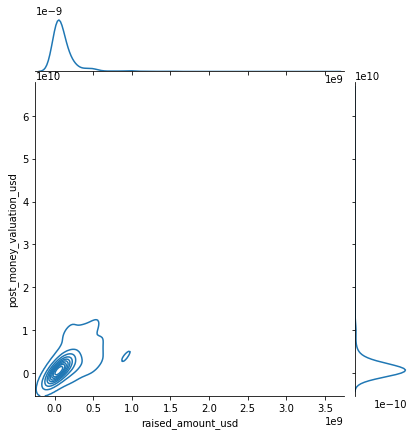

In [4]:
sns.jointplot(data=a, x='raised_amount_usd', y='post_money_valuation_usd', kind='kde')

In [5]:
a['level'] = [abs(x - a.post_money_valuation_usd.describe()['mean'])//a.post_money_valuation_usd.describe()['std'] for x in a.post_money_valuation_usd]
a

,raised_amount_usd,post_money_valuation_usd,level
0,85000000.0,1.000000e+09,0.0
1,9200000.0,4.920000e+07,0.0
2,15000000.0,3.050000e+08,0.0
3,23956365.0,4.791273e+07,0.0
4,186000000.0,1.000000e+09,0.0
...,...,...,...
712,500000.0,3.000000e+06,0.0
713,36000000.0,1.040000e+08,0.0
714,30000000.0,3.300000e+08,0.0
715,250000000.0,1.550000e+09,0.0


In [7]:
from sklearn.metrics import mean_absolute_percentage_error
a['pred'] = [pow(x, 1.1) for x in a.raised_amount_usd]
mean_absolute_percentage_error(a['post_money_valuation_usd'], a['pred'])

0.5317521441773837

In [ ]:
Xgb.regressor{'objective': 'reg:squaredlogerror',
'base_score': 0.5,
'booster': 'gbtree',
'colsample_bylevel': 1,
'colsample_bynode': 1,
'colsample_bytree': 1,
'gamma': 0,
'gpu_id': -1,
'importance_type': 'gain',
'interaction_constraints': '',
'learning_rate': 0.100000001,
'max_delta_step': 0,
'max_depth': 100,
'min_child_weight': 1,
'missing': nan,
'monotone_constraints': '()',
'n_estimators': 100,
'n_jobs': 12,
'num_parallel_tree': 1,
'random_state': 0,
'reg_alpha': 0,
'reg_lambda': 1,
'scale_pos_weight': 1,
'subsample': 1,
'tree_method': 'exact',
'validate_parameters': 1,
'verbosity': None,
'eta': 0.1}

In [5]:
#sns.displot(a['raised_amount_usd'], kind = 'kde')

In [74]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=1000000, min_samples = 10).fit(a)
labels = db.labels_
a['label'] = labels
a

,raised_amount_usd,count,label
12552,5.000000e+04,1,0
15025,2.397060e+05,1,0
8177,2.500000e+05,1,0
1698,5.000000e+05,2,0
9832,5.000000e+05,2,0
...,...,...,...
8348,1.500000e+09,2,-1
3430,1.500000e+09,2,-1
8674,1.800000e+09,1,-1
12758,2.500000e+09,1,-1


In [75]:
set(labels)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}

In [76]:
lab = a['label'].values.astype(int)
lab = lab.ravel()
lab

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4, -1, -1, -1,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7, -1,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8, -1, -1, -1, -1,  9,  9,  9,  9,
        9,  9,  9,  9,  9

In [77]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

In [78]:
data = a['raised_amount_usd'].values
data

array([5.00000000e+04, 2.39706000e+05, 2.50000000e+05, 5.00000000e+05,
       5.00000000e+05, 6.75000000e+05, 9.00000000e+05, 1.00000000e+06,
       1.00000000e+06, 1.00000000e+06, 1.20000000e+06, 1.25000000e+06,
       1.30000000e+06, 1.40000000e+06, 1.50000000e+06, 1.50000000e+06,
       1.50000000e+06, 1.60000000e+06, 1.85000000e+06, 2.00000000e+06,
       2.00000000e+06, 2.30000000e+06, 2.50000000e+06, 2.70000000e+06,
       2.70000000e+06, 3.00000000e+06, 3.00000000e+06, 3.00000000e+06,
       3.00000000e+06, 3.00000000e+06, 3.00000000e+06, 3.00000000e+06,
       3.00000000e+06, 3.20000000e+06, 3.40000000e+06, 3.71000000e+06,
       3.80000000e+06, 4.00000000e+06, 4.50000000e+06, 4.50000000e+06,
       4.55999700e+06, 4.70000000e+06, 5.00000000e+06, 5.00000000e+06,
       5.00000000e+06, 5.00000000e+06, 5.00000000e+06, 5.00000000e+06,
       5.00000000e+06, 5.05000000e+06, 5.50000000e+06, 5.50000000e+06,
       6.00000000e+06, 6.00000000e+06, 6.00000000e+06, 6.00000000e+06,
      

In [79]:
data.shape

(717,)

In [82]:
clst = AgglomerativeClustering(linkage='ward', distance_threshold=None, n_clusters=20)
out = clst.fit_predict(data.reshape(-1, 1))
a['label'] = out
a = a.drop_duplicates().reset_index(drop=True)
a.to_csv('testing.csv')
a

,raised_amount_usd,count,label
0,5.000000e+04,1,5
1,2.397060e+05,1,5
2,2.500000e+05,1,5
3,5.000000e+05,2,5
4,6.750000e+05,1,5
...,...,...,...
247,1.400000e+09,1,6
248,1.500000e+09,2,6
249,1.800000e+09,1,13
250,2.500000e+09,1,15


In [67]:
for idx, x in enumerate(data.squeeze()):
    print('object {}: cluster {}'.format(x, out[idx]))

object 50000.0: cluster 5
object 239706.0: cluster 5
object 250000.0: cluster 5
object 500000.0: cluster 5
object 500000.0: cluster 5
object 675000.0: cluster 5
object 900000.0: cluster 5
object 1000000.0: cluster 5
object 1000000.0: cluster 5
object 1000000.0: cluster 5
object 1200000.0: cluster 5
object 1250000.0: cluster 5
object 1300000.0: cluster 5
object 1400000.0: cluster 5
object 1500000.0: cluster 5
object 1500000.0: cluster 5
object 1500000.0: cluster 5
object 1600000.0: cluster 5
object 1850000.0: cluster 5
object 2000000.0: cluster 5
object 2000000.0: cluster 5
object 2300000.0: cluster 5
object 2500000.0: cluster 5
object 2700000.0: cluster 5
object 2700000.0: cluster 5
object 3000000.0: cluster 5
object 3000000.0: cluster 5
object 3000000.0: cluster 5
object 3000000.0: cluster 5
object 3000000.0: cluster 5
object 3000000.0: cluster 5
object 3000000.0: cluster 5
object 3000000.0: cluster 5
object 3200000.0: cluster 5
object 3400000.0: cluster 5
object 3710000.0: cluster 5


In [60]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [61]:
plot_dendrogram(clst)

AttributeError: 'AgglomerativeClustering' object has no attribute 'distances_'